In [1]:
import sys
import time
import os
import warnings

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

import numpy as np
import fitsio
from astropy.io import fits
import numpy.ma as ma

sys.path.insert(0, '/home/bekah/gphoton_working')
sys.path.insert(0, '/home/bekah/gphoton_working/gPhoton')

from photutils.aperture import CircularAperture
from photutils.utils import make_random_cmap
from skimage.measure import EllipseModel
from matplotlib.patches import Ellipse

import pandas as pd 

In [2]:
def derive_flux_expressions():
    from cytoolz import valfilter
    import sympy as sp

    infinity = sp.sympify('oo')
    A, n, sigma, r, r0, tau_b, tau_f, epsilon = sp.symbols(
        'A,n,sigma,r,r0,tau_b,tau_f, epsilon', positive=True
    )

    sym_gauss2d = A * sp.exp(-(r ** 2 / sigma ** 2))
    total_flux = sp.Integral(sym_gauss2d, (r, 0, infinity)).doit()
    center_flux = sp.Integral(sym_gauss2d, (r, 0, r0)).doit()
    flux_threshold_radius = sp.solve(
        total_flux - center_flux - tau_f, r0
    )[0]
    annulus_flux = sp.Integral(
        sym_gauss2d, (r, r0, r0 + epsilon)
    ).doit()
    annulus_area = sp.pi * ((r0 + epsilon) ** 2 - r0 ** 2)
    annulus_surface_brightness = annulus_flux / annulus_area
    instantaneous_brightness = sp.limit(
        annulus_surface_brightness, epsilon, 0
    )
    brightness_threshold_radius = sp.solve(
        instantaneous_brightness - tau_f, r0
    )[0]
    return valfilter(
        lambda f: isinstance(f, sp.core.expr.Expr), locals()
    )

In [ ]:
derive_flux_expressions()

In [3]:
from pyarrow import parquet

from gPhoton.parquet_utils import parquet_to_ndarray

from astropy.table import Table

from gPhoton.aspect import load_aspect_solution

from gPhoton.io.raw6 import load_raw6

Things I want to do today: 

- test astrometry.net on many different frames of an eclipse, see how similar the answers are 
- figure out all the ways to speed up astrometry.net & implement 
    -> low hanging fruit: code to use known WCS info to narrow down which index files are used 
    -> use source list from my own source extraction? 

In [4]:
def get_image_file(eclipse, band):
    from gPhoton.reference import eclipse_to_paths
    from gPhoton.coadd import zero_flag_and_edge
    # image info
    eclipse, band, depth, compression = eclipse, band, 30, "rice"
    galex_file_paths = eclipse_to_paths(eclipse, '/home/bekah/gphoton_working/test_data', depth,
                                        compression)
    # image to hdul
    hdul = fitsio.FITS(galex_file_paths[band]['image'])
    cnt, flag, edge = [hdu.read() for hdu in hdul[1:4]]
    
    masked_cnt_image = zero_flag_and_edge(cnt, flag, edge)
    return masked_cnt_image

In [5]:
def look_at_hdul(eclipse, band):
    from gPhoton.reference import eclipse_to_paths
    from gPhoton.coadd import zero_flag_and_edge
    # image info
    eclipse, band, depth, compression = eclipse, band, 30, "rice"
    galex_file_paths = eclipse_to_paths(eclipse, '/home/bekah/glcat/astrometry', depth,
                                        compression)
    # image to hdul
    hdul = fitsio.FITS(galex_file_paths[band]['image'])
    
    return hdul 

In [6]:
def centile_clip(image, centiles=(0, 90)):
    """
    simple clipping function that clips values above and below a given
    percentile range
    """
    finite = np.ma.masked_invalid(image)
    bounds = np.percentile(finite[~finite.mask].data, centiles)
    result = np.ma.clip(finite, *bounds)
    
    if isinstance(image, np.ma.MaskedArray):
        
        return result
    
    return result.data

In [7]:
# loading aspect table 
parq  = parquet.read_table('/home/bekah/gphoton_working/gPhoton/aspect/aspect.parquet')
aspect = parq.to_pandas()
#aspect["eclipse"==9869]

In [ ]:
# boresight parquet 
parq  = parquet.read_table('/home/bekah/gphoton_working/gPhoton/aspect/boresight.parquet')
bore = parq.to_pandas()

In [ ]:
aspect[aspect["eclipse"]==9869]

In [ ]:
bore[bore["eclipse"]==9869]

In [ ]:
movie = fits.open("/home/bekah/glcat/astrometry/e23456/e23456-nd-15s-rice.fits")

In [ ]:
movie[1].header

In [ ]:
my_data = pd.read_csv("/home/bekah/glcat/astrometry/aspect_correction/23456_aspect_soln")

In [ ]:
my_data = my_data.transpose()

In [ ]:
my_data

In [ ]:
my_data_sip = pd.read_csv("/home/bekah/glcat/astrometry/aspect_correction/21442_aspect_soln_sip")
my_data_sip = my_data_sip.transpose()
my_data_sip

In [ ]:
my_data_0center = pd.read_csv("/home/bekah/glcat/astrometry/aspect_correction/21442_aspect_soln_0center")
my_data_0center  = my_data_0center.transpose()
my_data_0center 

In [ ]:
my_data_6s = pd.read_csv("/home/bekah/glcat/astrometry/aspect_correction/21442_aspect_soln_6s")
my_data_6s  = my_data_6s.transpose()
my_data_6s 

In [ ]:
my_data_10s = pd.read_csv("/home/bekah/glcat/astrometry/aspect_correction/21442_aspect_soln_10s")
my_data_10s  = my_data_10s.transpose()
my_data_10s 

In [ ]:
my_data_3s = pd.read_csv("/home/bekah/glcat/astrometry/aspect_correction/21442_aspect_soln_3s")
my_data_3s  = my_data_3s.transpose()
my_data_3s 

In [ ]:
my_data_1s_sip = pd.read_csv("/home/bekah/glcat/astrometry/aspect_correction/21442_aspect_soln_1s_sip")
my_data_1s_sip  = my_data_1s_sip.transpose()
my_data_1s_sip

In [ ]:
my_data_1s_lowerDAO = pd.read_csv("/home/bekah/glcat/astrometry/aspect_correction/781_aspect_soln_1s_thresh0.9_size3")
my_data_1s_lowerDAO  = my_data_1s_lowerDAO.transpose()
my_data_1s_lowerDAO

In [ ]:
my_data_1s_im = pd.read_csv("/home/bekah/glcat/astrometry/aspect_correction/21442_aspect_soln_1s_image_sip")
my_data_1s_im  = my_data_1s_im.transpose()
my_data_1s_im

In [ ]:
my_data_1s_fill = pd.read_csv("/home/bekah/glcat/astrometry/aspect_correction/21442_aspect_soln_1s_thresh0.8_size2_wImageForFails")
my_data_1s_fill  = my_data_1s_fill.transpose()
my_data_1s_fill.index

In [ ]:
my_data_2s_dose = pd.read_csv("/home/bekah/glcat/astrometry/aspect_correction/21442_aspect_soln_2s_thresh1.0_size3_dose")
my_data_2s_dose  = my_data_2s_dose.transpose()
my_data_2s_dose

In [ ]:
d9869 = pd.read_csv("/home/bekah/glcat/astrometry/aspect_correction/09869_aspect_soln_1s_thresh1_size4_pixelScale")
d9869  = d9869.transpose()


In [ ]:
d9869_dose = pd.read_csv("/home/bekah/glcat_tests/aspect_solns/e09869_aspect_soln_1s_thresh1_size3_dose_gaia_tycho")
d9869_dose  = d9869_dose.transpose()
d9869_dose 

In [ ]:
d9869_dose_2 = pd.read_csv("/home/bekah/glcat_tests/aspect_solns/e09869_aspect_soln_1s_thresh0.8_size3_dose_gaia_tycho")
d9869_dose_2  = d9869_dose_2.transpose()
d9869_dose_2

In [ ]:
aspect[aspect["eclipse"]==21442]["ra"]

In [ ]:
%matplotlib notebook
plt.scatter(aspect[aspect["eclipse"]==9869]["ra"],aspect[aspect["eclipse"]==9869]["dec"],c=aspect[aspect["eclipse"]==9869].index,alpha=0.7,s=20)
#plt.scatter(bore[bore["eclipse"]==21442]['ra0'],bore[bore["eclipse"]==21442]['dec0'], c="purple")
#plt.scatter(my_data_6s[0],my_data_6s[1],c="black",alpha=0.5)
#plt.scatter(my_data_3s[0],my_data_3s[1],marker='+',c="orange",alpha=0.5)
#plt.scatter(my_data_1s_im[0],my_data_1s_im[1],marker='s',c="yellow")
#plt.scatter(201.057617, 27.476043, marker='*',s=200, c="black")
#plt.scatter(my_data_2s_dose[0],my_data_2s_dose[1],marker="*",c="black",alpha=0.5)
#plt.scatter(my_data_1s_fill[0],my_data_1s_fill[1],marker='o',c=my_data_1s_fill.index.astype(int),alpha=0.6)
#plt.scatter(d9869[0],d9869[1],marker='o',c="red")
plt.scatter(d9869_dose_2 [0],d9869_dose_2 [1],marker='+',c="red",alpha=0.8)
plt.scatter(d9869_dose [0],d9869_dose [1],marker='o',c="orange",alpha=0.5)
plt.colorbar()


In [ ]:
plt.scatter(aspect[aspect["eclipse"]==21442]["ra"],aspect[aspect["eclipse"]==21442]["dec"],c="blue",alpha=0.7,s=20)
plt.scatter(my_data_1s_sip[0],my_data_1s_sip[1],marker="*",c="green",alpha=0.5)

In [ ]:
from astropy import wcs


In [ ]:
hdulist = fits.open("/home/bekah/glcat_tests/astrometry_temp/frame74.wcs")

In [ ]:
 w = wcs.WCS(hdulist[0].header)

    # Print out the "name" of the WCS, as defined in the FITS header
print(w.wcs.name)

In [ ]:
    # Print out all of the settings that were parsed from the header
w.wcs.print_contents()

In [ ]:
hdulist2 = fits.open("/home/bekah/glcat/astrometry/e09869/e09869-nd-1s-0-f0032-rice.fits")

In [ ]:
fits32 = fits.open("/home/bekah/glcat/astrometry/e09869/dose_t2_selection_2/e09869-nd-t0002-b00-f00008-g_dose.fits")

In [ ]:
fits32[0].header

In [ ]:
fits87_xy = fits.open("/home/bekah/glcat_tests/xylists_lower_thresh/e09869/e09869-nd-t0001-b00-f0031-g_dose.fits")


In [ ]:
from astropy.table import Table

table = Table.read('/home/bekah/glcat/astrometry/aspect_correction/frame36.xyls')
fits87_xy = table.to_pandas()

In [ ]:
fits87_xy

In [ ]:
from astropy import wcs


w = wcs.WCS(wcs32[0].header)
          # Print out the "name" of the WCS, as defined in the FITS header
          # Print out all of the settings that were parsed from the header
w.wcs.print_contents()


In [ ]:
%matplotlib notebook
plt.imshow(centile_clip(fits32[1].data[0],(0,99.99)))
plt.scatter(fits87_xy['X'],fits87_xy['Y'],s=0.5,c=fits87_xy.index)

In [ ]:
fits32[1].header

In [ ]:
np.median(fits32[1].data)

In [ ]:

#hdulist = fits.open("/home/bekah/gphoton_working/test_data/e09869/e09869-nd-1s-0-f0032-rice.fits")
%matplotlib notebook
plt.imshow(centile_clip(fits87_xy[0].data,(0,99.99)))

In [ ]:
def get_stars(image, threshold: float = 0.75, star_size: int = 2):
    """ run DAO on movie frames, sort by flux """
    from photutils import DAOStarFinder

    daofind = DAOStarFinder(fwhm=star_size, threshold=threshold, sharplo=0.00)
    star_list = daofind(image)
    if star_list is not None:
        print(f"{len(star_list)} stars found")
        return star_list
    else:
        print("no stars found for this frame.")
        return None

In [ ]:
%matplotlib notebook
plt.imshow(centile_clip(hdulist2[1].data[0],(0,99.99)))

In [ ]:
table = get_stars(fits87_xy[0].data,threshold=1,star_size=5)

In [ ]:
table

In [ ]:
%matplotlib notebook
plt.imshow(centile_clip(fits87_xy[0].data,(0,99.99)))
plt.scatter(table["xcentroid"],table["ycentroid"],s=0.2,marker='+')

In [9]:
df9869 = pd.read_csv('/home/bekah/glcat_tests/aspect_solns/e09869_aspect_soln_1s_thresh0.8_size3_dose_gaia_tycho')

In [10]:
df9869 = df9869.set_index('frame')

<IPython.core.display.Javascript object>


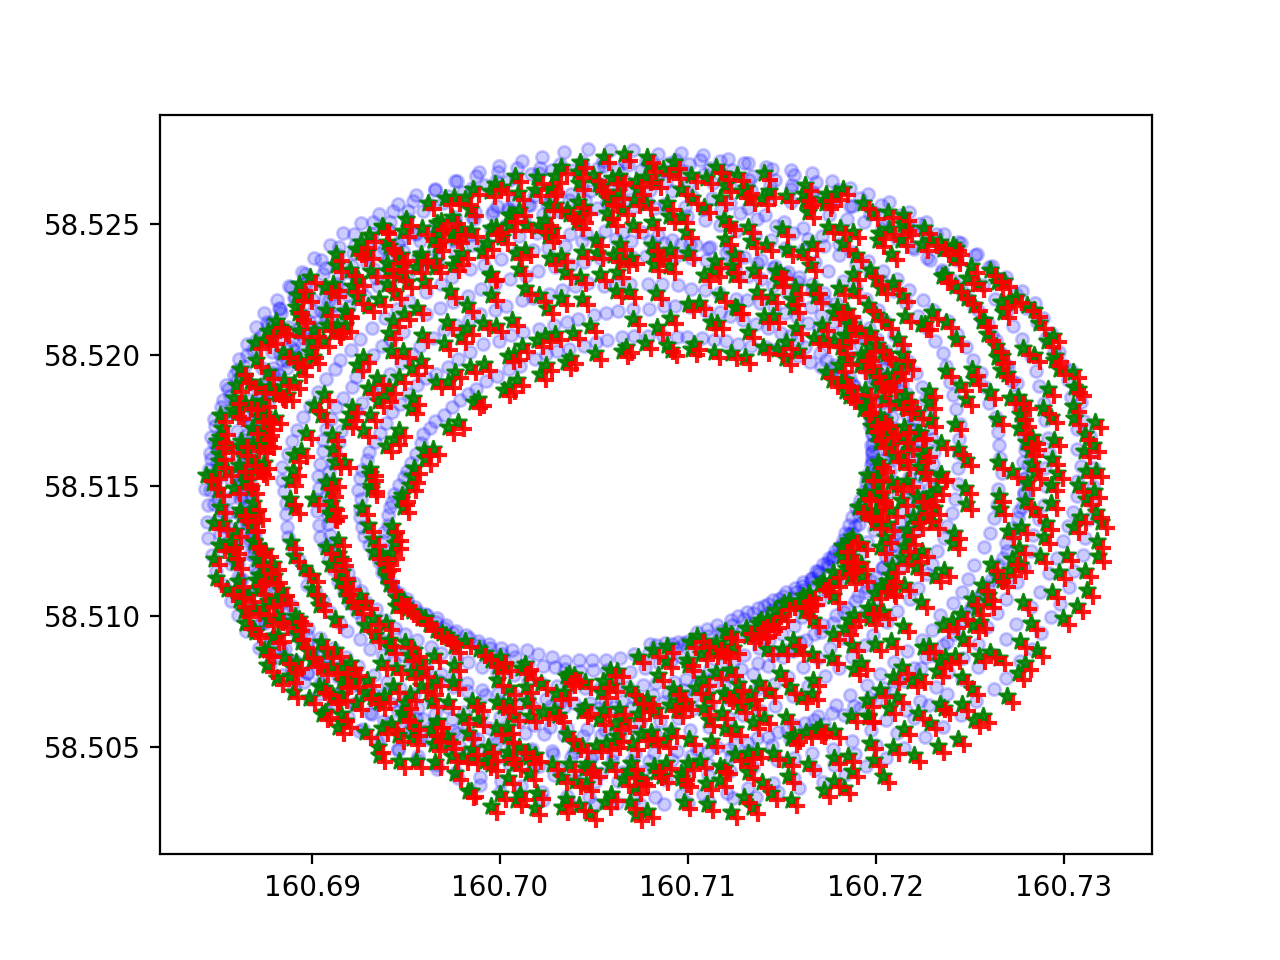

In [22]:
%matplotlib notebook
plt.scatter(aspect[aspect["eclipse"]==9869]["ra"],aspect[aspect["eclipse"]==9869]["dec"],c="blue",alpha=0.2,s=20)
plt.scatter(df9869["ra_tangent"],df9869["dec_tangent"],marker="*",c="green",alpha=0.9)
plt.scatter(df9869["ra_center"],df9869["dec_center"],marker="+",c="red",alpha=0.9)